In [24]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.ensemble import GradientBoostingClassifier
import shap
import matplotlib.pyplot as plt

In [18]:
# Load your data
df = pd.read_csv(r"..\data\Combined_dataset.csv")


# Drop missing values or handle them
data = df.dropna()
print(data)
# Encode categorical variables using LabelEncoder or one-hot encoding
label_columns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'poutcome', 'month', 'day']
label_encoders = {}  # Store the label encoders for inverse transformations if needed
for col in label_columns:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col].astype(str))
    label_encoders[col] = le  # Store the encoder for inverse transformations if needed

# Scaling numerical features
numerical_features = ['age', 'balance', 'duration', 'campaign', 'pdays', 'previous', 'cd_account', 
                      'securities', 'TransactionFrequency', 'Recency', 'AverageTransactionAmount']
scaler = StandardScaler()
data[numerical_features] = scaler.fit_transform(data[numerical_features])

# Define features and target variable
X = data.drop(columns=['y']) 
y = data['y']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

       age           job   marital  education default  balance  housing  loan  \
0       58    management   married   tertiary      no     2143        1     0   
1       44    technician    single  secondary      no       29        1     0   
2       33  entrepreneur   married  secondary      no        2        1     1   
3       35    management   married   tertiary      no      231        1     0   
4       28    management    single   tertiary      no      447        1     1   
...    ...           ...       ...        ...     ...      ...      ...   ...   
43349   51    technician   married   tertiary      no      825        0     0   
43350   71       retired  divorced    primary      no     1729        0     0   
43351   72       retired   married  secondary      no     5715        0     0   
43352   57   blue-collar   married  secondary      no      668        0     0   
43353   37  entrepreneur   married  secondary      no     2971        0     0   

         contact  duration 

### Model training 
Gradient Boosting and evaluate the model

In [19]:
# Initialize and train the Gradient Boosting model
model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
model.fit(X_train, y_train)

# Evaluate the model
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print(f"AUC-ROC Score: {roc_auc_score(y_test, y_pred_proba):.4f}")


Classification Report:
              precision    recall  f1-score   support

          no       0.92      0.97      0.95      7664
         yes       0.64      0.38      0.47      1007

    accuracy                           0.90      8671
   macro avg       0.78      0.67      0.71      8671
weighted avg       0.89      0.90      0.89      8671

AUC-ROC Score: 0.9234


### Model Explainability with SHAP
helps identify which features contribute most to predictions, guiding retention strategies.

 95%|=================== | 8239/8671 [00:11<00:00]       

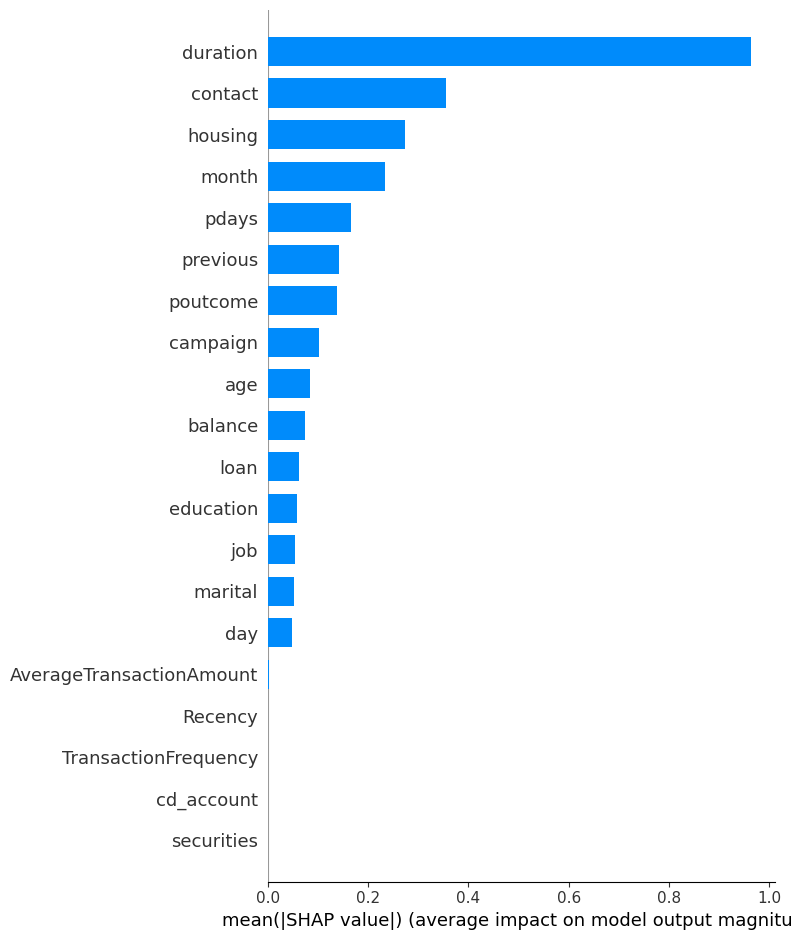

In [20]:
# Initialize SHAP Explainer with Gradient Boosting model
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_test)

# Plot summary of feature importance
shap.summary_plot(shap_values, X_test, plot_type="bar")
plt.show()


This SHAP summary plot provides insights into the top features influencing customer churn in the model. 
- Feature Importance: The graph ranks features by their average SHAP values (from top to bottom), higher bar means the feature has a stronger influence on the prediction of churn.

Top Predictive Features:
- **Duration** has the highest impact on churn predictions, suggesting that the amount of time (e.g., duration of interaction, transaction duration) is a key factor in determining whether a customer might churn.
- **Contact** also has a significant influence, possibly indicating the method of contact with the customer. For instance, some contact methods may be associated with higher churn risk.
- **Housing and Month** are also influential which could imply that customers’ housing status or the month in which data is collected affects churn likelihood.
- Lesser Influence of Some Features such as **AverageTransactionAmount** and **Recency** have very low SHAP values, indicating that they have minimal influence on the model’s predictions. This might mean that changes in these features don’t significantly affect the likelihood of churn.

### Adding churn risk scores to test data 
- Identify and prioritize high-risk customers. (e.g., with churn scores above 0.7)
- Implement a proactive early warning system.
- Tailor retention strategies based on risk levels.
- Measure the effectiveness of retention efforts.
- Reduce churn and improve customer lifetime value over time.

In [21]:
# Add churn risk scores to test data
X_test['churn_risk_score'] = y_pred_proba

# Define a threshold for high-risk customers
risk_threshold = 0.7
high_risk_customers = X_test[X_test['churn_risk_score'] > risk_threshold]

# Display high-risk customers for dashboard tracking
print("High-risk customers:")
print(high_risk_customers)


High-risk customers:
            age  job  marital  education  default   balance  housing  loan  \
41503 -0.739919    4        0          2        0  0.291055        0     0   
38629 -0.930054    4        2          2        0 -0.141856        0     0   
40107 -0.739919    4        2          2        0  0.140062        0     0   
43012  1.826898    0        1          1        0  0.782851        0     0   
32630  1.446628    4        1          2        0 -0.243176        0     0   
...         ...  ...      ...        ...      ...       ...      ...   ...   
40278 -0.739919    4        2          2        0  1.793416        0     0   
40103 -0.454717    9        1          2        0  1.066085        1     0   
42227 -1.405390    4        2          2        0 -0.372786        0     0   
38853 -0.739919    9        2          2        0  1.620383        1     0   
42800  1.826898    4        1          2        0 -0.342193        0     0   

       contact  duration  ...  previous  p

Example for provide recommendation for the customers with high churn risk, to retent the customers

In [22]:
def recommend_retention_actions(row):
    actions = []
    if row['TransactionFrequency'] < 5:
        actions.append("Send personalized offers to increase transaction frequency.")
    if row['Recency'] > 60:
        actions.append("Offer incentives for recent product usage.")
    if row['balance'] < 0:
        actions.append("Provide financial counseling or adjust account terms.")
    if row['AverageTransactionAmount'] < 100:
        actions.append("Offer discounts or rewards to encourage larger transactions.")
    return actions if actions else ["Monitor for changes in activity."]

# Apply retention actions to high-risk customers
high_risk_customers['retention_actions'] = high_risk_customers.apply(recommend_retention_actions, axis=1)

# Display recommendations
for index, row in high_risk_customers.iterrows():
    print(f"\nCustomer ID: {index}")
    for action in row['retention_actions']:
        print(f"- {action}")



Customer ID: 41503
- Send personalized offers to increase transaction frequency.
- Offer discounts or rewards to encourage larger transactions.

Customer ID: 38629
- Send personalized offers to increase transaction frequency.
- Provide financial counseling or adjust account terms.
- Offer discounts or rewards to encourage larger transactions.

Customer ID: 40107
- Send personalized offers to increase transaction frequency.
- Offer discounts or rewards to encourage larger transactions.

Customer ID: 43012
- Send personalized offers to increase transaction frequency.
- Offer discounts or rewards to encourage larger transactions.

Customer ID: 32630
- Send personalized offers to increase transaction frequency.
- Provide financial counseling or adjust account terms.
- Offer discounts or rewards to encourage larger transactions.

Customer ID: 43182
- Send personalized offers to increase transaction frequency.
- Provide financial counseling or adjust account terms.
- Offer discounts or rewa

C:\Users\Chen yiru\AppData\Local\Temp\ipykernel_25556\3537709555.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  high_risk_customers['retention_actions'] = high_risk_customers.apply(recommend_retention_actions, axis=1)



### Insights for Retention Strategy
The most important features (like duration, contact, housing, and month) offer actionable insights. 
- Focusing on customers with short interaction durations or those contacted infrequently could help reduce churn.
- Considering specific months or seasons with higher churn rates might allow for targeted retention efforts.

In summary, this SHAP plot helps identify key drivers of churn and highlights which features could be targeted in retention strategies to reduce churn.

In [23]:
# Example of setting up placeholders to track metrics
from datetime import datetime
from sklearn.metrics import accuracy_score

# Mock implementation of retention metrics for tracking
def calculate_clv(customer_data):
    # Placeholder: replace with actual CLV formula
    return customer_data['balance'].mean() * 12

def calculate_renewal_rate(predictions, true_values):
    # Renewal rate calculation based on accuracy for demonstration
    return accuracy_score(true_values, predictions)

# Calculate mock metrics

clv = calculate_clv(df)
renewal_rate = calculate_renewal_rate(y_pred, y_test)
print(f"Estimated CLV: ${clv:.2f}")
print(f"Renewal Rate: {renewal_rate * 100:.2f}%")


Estimated CLV: $16262.72
Renewal Rate: 90.30%


Tracking metrics (measuring the effectiveness of retention strategies and the overall business health in customer relationship management):
1. Customer Lifetime Value (CLV) 
estimates the total revenue a customer is expected to generate over their lifetime. 
2. Renewal Rate
the percentage of customers who renew a subscription or continue their relationship with the company over time. 